# Dog Adoption Speed Predictions

In [749]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This dataset is from Kaggle

https://www.kaggle.com/c/petfinder-adoption-prediction/rules

This is a multi-class classification task to predict the speed of adoption of an animal in a shelter. The dataset contains information on cats and dogs, so this notebook will focus on dogs only.


Data Fields
* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. 
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

Adoption Speed

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [340]:
train = pd.read_csv("C:/Users/imoge/Projects/Datasets/petadoptiontrain.csv")
labels = pd.read_csv("C:/Users/imoge/Projects/Datasets/breed_labels.csv")

In [341]:
print(train.shape)
print(test.shape)
print(labels.shape)

(14993, 24)
(3948, 23)
(307, 3)


In [342]:
train.head(2)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0


In [343]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

In [344]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

# Data Cleaning

In [345]:
print(labels.shape)
labels.head()

(307, 3)


,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [346]:
# Drop rows of cats
labels = labels[labels["Type"] == 1]
labels.drop(columns = "Type",axis = 2,inplace = True)
print(labels.shape)

(241, 2)


In [347]:
# Drop rows that contain cat information
train2 = train[train["Type"] == 1]
test2 = test[test["Type"] == 1]

In [348]:
# Drop columns not required
train2 = train2.drop(columns = ["PetID","Name","RescuerID","Type","Breed2"],axis = 1)
test2 = test2.drop(columns = ["PetID","Name","RescuerID","Type","Breed2"],axis = 1)

In [349]:
print(train2.shape)
print(test2.shape)

(8132, 19)
(1871, 18)


In [350]:
train2.dtypes

Age                int64
Breed1             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
VideoAmt           int64
Description       object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object

In [351]:
train2.describe()

,Age,Breed1,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000,8132.000000
mean,12.906173,262.088416,1.738072,2.077595,2.602312,1.329193,1.948475,1.465814,1.668101,1.542425,1.910723,1.037875,1.526808,24.294638,41342.316773,0.058657,3.731062,2.615101
std,21.377588,80.360298,0.639196,1.593556,2.639396,2.633188,0.502045,0.585091,0.720179,0.731292,0.596714,0.203986,1.536229,90.085547,30.153834,0.364286,3.478076,1.144104
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,2.000000,218.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,1.000000,2.000000
50%,3.000000,307.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,3.000000
75%,12.000000,307.000000,2.000000,2.000000,5.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41332.000000,0.000000,5.000000,4.000000
max,255.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


In [352]:
# Concat the colour types into one colour
cols = ["Color1", "Color2","Color3"]
train2['Colour'] = train2[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
train2.drop(columns = ["Color1","Color2","Color3"],axis = 1, inplace = True)

In [353]:
#Convert photo amounts to integer
train2["PhotoAmt"] = train2["PhotoAmt"].astype(int)

# Visualisation

In [354]:
train2.columns

Index(['Age', 'Breed1', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated',
       'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State',
       'VideoAmt', 'Description', 'PhotoAmt', 'AdoptionSpeed', 'Colour'],
      dtype='object')

### Adoption Speed

In [355]:
train2["AdoptionSpeed"].value_counts()

4    2414
2    2164
3    1949
1    1435
0     170
Name: AdoptionSpeed, dtype: int64

Classes are not balanced

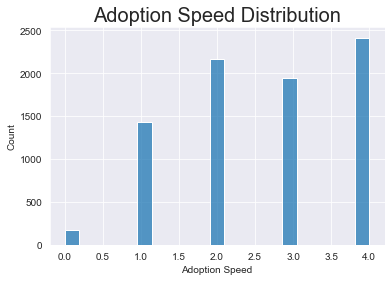

In [356]:
fig, ax = plt.subplots()
sns.histplot(data=train2, x="AdoptionSpeed",bins = 'auto')
plt.title("Adoption Speed Distribution",fontsize = 20)
plt.xlabel("Adoption Speed");

Most dogs take longer to rehome with only a small number rehomed at the fasted rate

The speed of adoption is the target variable and we need to identify relationships between the predictor variables and this target. The following charts focus on trying to determine whether there are relationships between each predictor and the target.

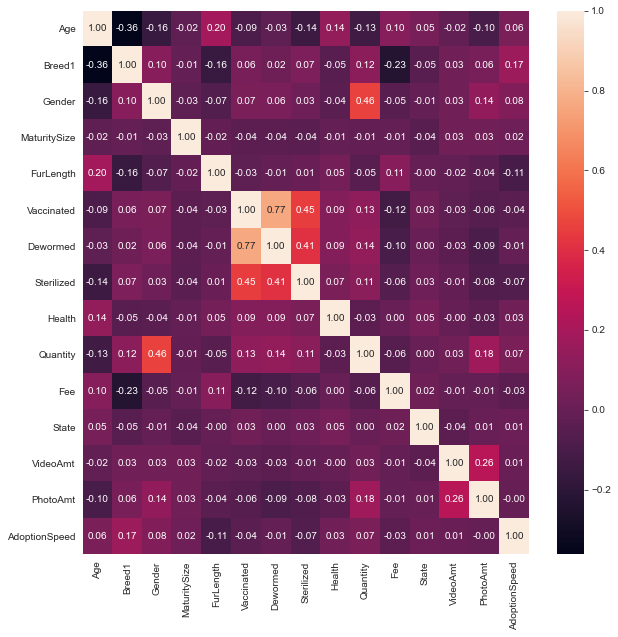

In [357]:
# Heatmap to get a quick feel for the data
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(data = train2.corr(), annot = True, fmt='.2f');

There are no strong correlations between adoption speed and the variables but there are weak positives with breed, age, gender, maturity, health, vaccination, worming and sterilisation status(negative on chart but the scale is reverse for these variables) quantity, state and amount of video and weak negative relationships with fur length, the fee charged and interestingly the number of photos uploaded.

Based on this, a few of the variables will be examined further, notably the breed, age and gender, fur length and sterilisation status. The fee charged will also be included.

### Age of Dog (months)

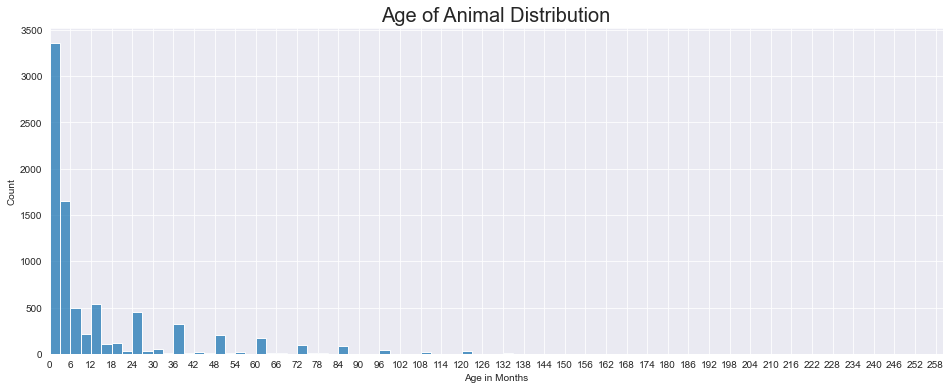

In [358]:
fig, ax = plt.subplots(figsize = (16,6))
sns.histplot(data=train2, x="Age",binwidth = 3, bins = 'auto')
ax.set_xlim(1,260)
ax.set_xticks(range(0,261,6))
plt.title("Age of Animal Distribution",fontsize = 20)
plt.xlabel("Age in Months");

Data is positive skew with most dogs being up to six months old. The maximum age is 255 months (21 years).

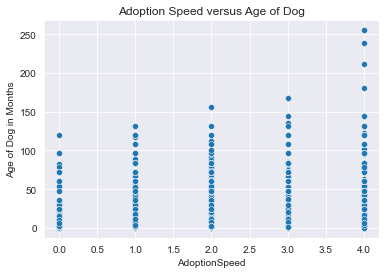

In [359]:
# Relationship with speed of adoption
sns.scatterplot(data = train2, y = "Age", x = "AdoptionSpeed")
plt.title("Adoption Speed versus Age of Dog")
plt.ylabel("Age of Dog in Months");

It appears there might be some relationship between the age of dog and adoption speed

### Breed of Dog

In [360]:
top_breeds = pd.DataFrame(train2["Breed1"].value_counts().head(15)).reset_index()
top_breeds.columns = ["BreedID","Number"]
top_breeds.set_index("BreedID",inplace = True)

In [361]:
# Join the breed name to the breed top breed dataframe
labels2 = labels.set_index("BreedID")
top_breeds = top_breeds.join(labels2)
top_breeds.head()

,Number,BreedName
BreedID,,
307,5923,Mixed Breed
141,205,Labrador Retriever
205,189,Shih Tzu
179,167,Poodle
218,161,Terrier


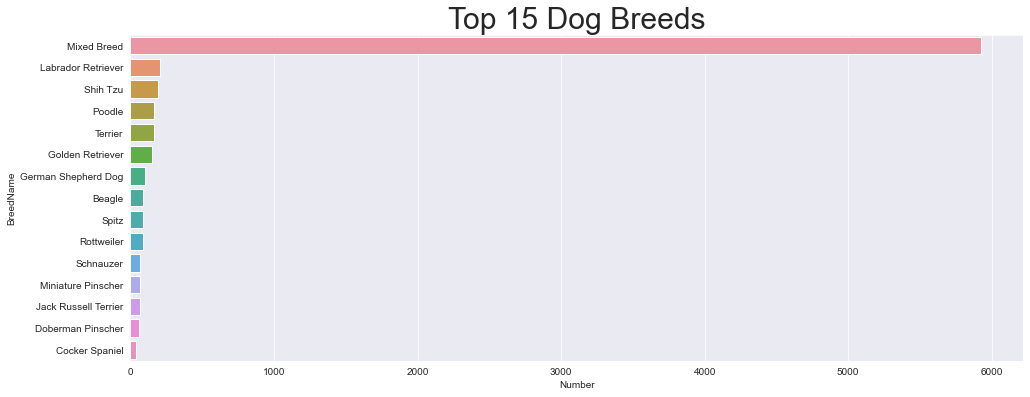

In [362]:
# Plot the total crashes
fig, ax = plt.subplots(figsize = (16,6))
sns.set_color_codes("pastel")
sns.barplot(x="Number", y="BreedName", data=top_breeds)
plt.title("Top 15 Dog Breeds", fontsize = 30);

Most dogs are mixed breed in the shelter

In [363]:
mixed = pd.DataFrame(train2[train2["Breed1"] == 307]["Breed1"])
other = pd.DataFrame(train2[train2["Breed1"] != 307]["Breed1"])

In [364]:
mixed.describe().T

,count,mean,std,min,25%,50%,75%,max
Breed1,5923.0,307.0,0.0,307.0,307.0,307.0,307.0,307.0


In [365]:
other.describe().T

,count,mean,std,min,25%,50%,75%,max
Breed1,2209.0,141.666818,62.146438,0.0,103.0,141.0,200.0,240.0


The mean and median adoption speed for mixed breeds is longer than the other breeds. Could test this with t-test (difference in mean values)

### Gender

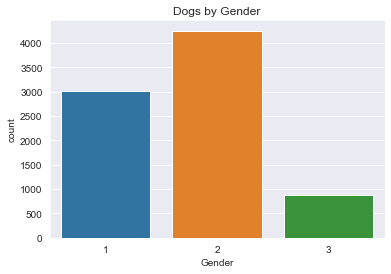

In [366]:
fig, ax = plt.subplots()
sns.countplot(data = train2, x = "Gender")
plt.title("Dogs by Gender");

Most dogs in the adoption centre are female, mixed groups are the lowest in number

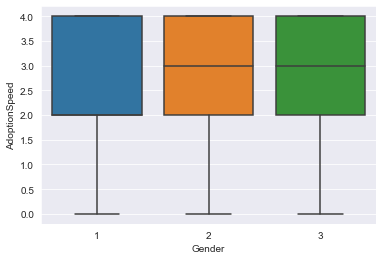

In [367]:
sns.boxplot(data = train2, x = "Gender", y = "AdoptionSpeed");

In [368]:
print(train2[train2["Gender"] == 1]["AdoptionSpeed"].median())
print(train2[train2["Gender"] == 2]["AdoptionSpeed"].median())
print(train2[train2["Gender"] == 3]["AdoptionSpeed"].median())

2.0
3.0
3.0


There appear to be a difference in mean adoption speeds between male and female or mixed groups of dogs

### Fur length

In [369]:
train2["FurLength"].value_counts()

1    4724
2    3028
3     380
Name: FurLength, dtype: int64

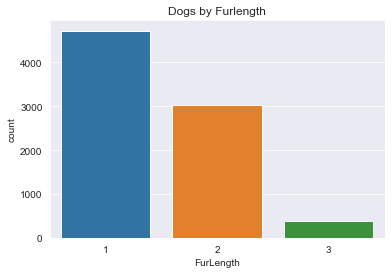

In [370]:
fig, ax = plt.subplots()
sns.countplot(data = train2, x = "FurLength")
plt.title("Dogs by Furlength");

Most animals are short-haired

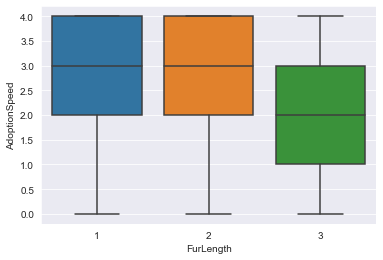

In [371]:
sns.boxplot(data = train2, x = "FurLength", y = "AdoptionSpeed");

Longer haired dogs appear to have a shorter mean adoption speed than short and medium haired

### Sterilisation Status

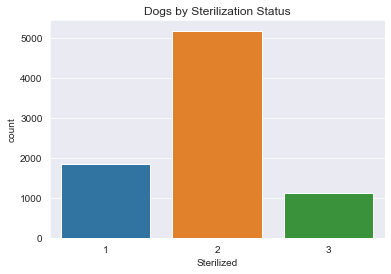

In [372]:
fig, ax = plt.subplots()
sns.countplot(data = train2, x = "Sterilized")
plt.title("Dogs by Sterilization Status");

Most dogs are unsterilized

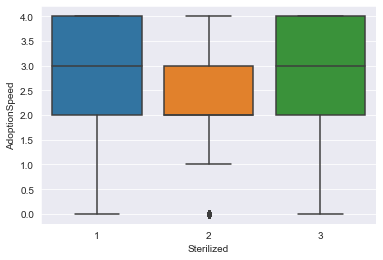

In [373]:
sns.boxplot(data = train2, x = "Sterilized", y = "AdoptionSpeed");

In [374]:
print(train2[train2["Sterilized"] == 1]["AdoptionSpeed"].median())
print(train2[train2["Sterilized"] == 2]["AdoptionSpeed"].median())
print(train2[train2["Sterilized"] == 3]["AdoptionSpeed"].median())

3.0
2.0
3.0


# Data Engineering

In [661]:
train2.columns

Index(['Age', 'Breed1', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated',
       'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State',
       'VideoAmt', 'Description', 'PhotoAmt', 'AdoptionSpeed', 'Colour'],
      dtype='object')

In [662]:
data = train2[["Breed1","Age","Gender","FurLength","Sterilized","AdoptionSpeed"]]
data.head()

,Breed1,Age,Gender,FurLength,Sterilized,AdoptionSpeed
2,307,1,1,2,2,3
3,307,4,2,1,2,2
4,307,1,1,1,2,2
7,307,0,2,1,2,3
10,307,2,1,1,2,1


In [663]:
# Drop the category of "Not Sure" from Sterilized
data_train = data[data["Sterilized"] != 3]

In [664]:
# Drop the 'Not Specified' fur length
data_train = data_train[data_train["FurLength"]!= 0]

In [665]:
# Drop the 'Mixed Gender'  as doesn't seem to vary much in relationship as compared to female
data_train = data_train[data_train["Gender"] != 3]

In [666]:
# Set X and y
X = data_train.drop(columns = "AdoptionSpeed", axis =1)
y = data_train["AdoptionSpeed"]

In [667]:
# Create dummy variables for X
X = X[["Gender","Sterilized","FurLength"]].astype("category")
proc = pd.get_dummies(X["FurLength"])

In [668]:
# Concat the processed column back to the other categorical variables and then back to the numerical variables
proc = pd.concat([X,proc],axis = 1).drop(columns = ["FurLength"])
proc.columns = ["Gender","Sterilized","ShortHair","MedHair","LongHair"]
X = pd.concat([proc,num],axis = 1)

In [669]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5036, 6) (1260, 6) (5036,) (1260,)


In [670]:
# Scale 'Age' concat to original training and test data and drop the unscaled Age column
scale = StandardScaler()
scaled_age = pd.DataFrame(scale.fit_transform(pd.DataFrame(X_train["Age"])))
scaled_age_test = pd.DataFrame(scale.fit_transform(pd.DataFrame(X_test["Age"])))

X_train = pd.concat([scaled_age,X_train.reset_index()],axis = 1)
X_train = X_train.set_index("index")
X_train.rename(columns={0:'Age'}, inplace=True)

X_test = pd.concat([scaled_age_test,X_test.reset_index()],axis = 1)
X_test = X_test.set_index("index")
X_test.rename(columns={0:'Age'}, inplace=True)

# Build Model

In [671]:
lr = LogisticRegression(class_weight = "balanced", multi_class = "auto",max_iter=1000)
rf = RandomForestClassifier(class_weight = "balanced")

### Logistic Regression

In [672]:
model = lr.fit(X_train,y_train)
y_pred = pd.DataFrame(model.predict(X_test))

In [673]:
y_test = pd.DataFrame(y_test).reset_index()
y_test.drop(columns = "index",axis = 1,inplace = True)
y_test.columns = ["Actual"]
results_lr = pd.concat([y_test,y_pred],axis =1)
results_lr.columns =["Actual","Pred"]
results_lr.head()

,Actual,Pred
0,2,4
1,1,3
2,3,0
3,1,1
4,0,0


model.score(X_train,y_train)

In [678]:
model.score(X_test, y_test)

0.30793650793650795

### Random Forest Classifier

In [679]:
model2 = rf.fit(X_train,y_train)
y_pred2 = pd.DataFrame(model2.predict(X_test))

In [680]:
y_test = pd.DataFrame(y_test).reset_index()
y_test.drop(columns = "index",axis = 1,inplace = True)
y_test.columns = ["Actual"]
results_rf = pd.concat([y_test,y_pred2],axis =1)
results_rf.columns =["Actual","Pred"]
results_rf.head()

,Actual,Pred
0,2,4
1,1,3
2,3,3
3,1,2
4,0,1


In [681]:
print(model2.score(X_train,y_train))
print(model2.score(X_test, y_test))

0.3745035742652899
0.30158730158730157


The results from this model based on the features chosen is not great. The lack of correlation in the heatmap suggested that there were no really strong relationships in this data to predict the speed at which a dog would be adopted. An alternative might be to look at the descriptions and determine the sentiment and whether this had any relationship with the speed of adoption.

# Sentiment

In [695]:
train2["Description"].sample(20)

14244    Benji was found by a fellow rescuer/dog lover ...
13647    LADY came to my sister's house by chance coz g...
3311     Kai KAi was spayed and fully vaccinated. She i...
393      This pup is happy and affectionate and fine wi...
589      She is a very good companion dog. Small enough...
7689     Picked up from a big deep longkang, very smart...
3928     Long legged and lanky, Julie appears to have s...
3713                                          For Adoption
390      A very unexpected guest this morning. A very a...
2142                                          For Adoption
1269     We have 6 cute puppies are waiting for a home ...
9552     A cute and adorable puppy...Needs a lot of att...
69       Jasz is a very friendly and well-behaved Schna...
3197     Healthy, gentle-natured 3 year old female Engl...
12056    she has been spayed...she is a good companion ...
12538               Area: Bayan Lepas, Penang. CoContact :
10046    Angel loves people, especially children. Looki.

In [721]:
# Clean up the text to remove upper case, white space and punctuation
train2["Cleaned_text"] = train2.Description.str.lower()
train2["Cleaned_text"] = train2["Cleaned_text"].str.strip()
train2['Cleaned_text']=train2['Cleaned_text'].apply(str) # set float values to strings

In [723]:
train2["Cleaned_text"] = train2["Cleaned_text"].apply(lambda x: nltk.word_tokenize(x))

In [728]:
# Remove punctuation, numerics, ascii characters and stopwords
punc = string.punctuation
train2["Cleaned_text"] = train2["Cleaned_text"].apply(lambda x: [word for word in x if word not in punc])
train2["Cleaned_text"] = train2["Cleaned_text"].apply(lambda x: [n for n in x if not n.isnumeric()])
train2["Cleaned_text"] = train2["Cleaned_text"].apply(lambda x: [e for e in x if e.encode("ascii","ignore")])
stop = stopwords.words('english')
train2["Cleaned_text"] = train2["Cleaned_text"].apply(lambda x: [w for w in x if w not in stop])

In [730]:
train2.Cleaned_text.head()

2     [pregnant, mother, dumped, irresponsible, owne...
3     [good, guard, dog, alert, active, obedience, w...
4     [handsome, yet, cute, boy, adoption, playful, ...
7     [siu, pak, give, birth, 13/6/10, 6puppies, int...
10    [serious, adopter, please, sms, call, details,...
Name: Cleaned_text, dtype: object

In [ ]:
# Remove dates

In [735]:
# Join back to strings
train2["Cleaned_text"] = train2["Cleaned_text"].apply(lambda x: ' '.join(x))

In [736]:
# Get sentiment of each piece using VADER
sia = SentimentIntensityAnalyzer()
train2["VComp"] = train2["Cleaned_text"].apply(lambda x: sia.polarity_scores(x)['compound'])

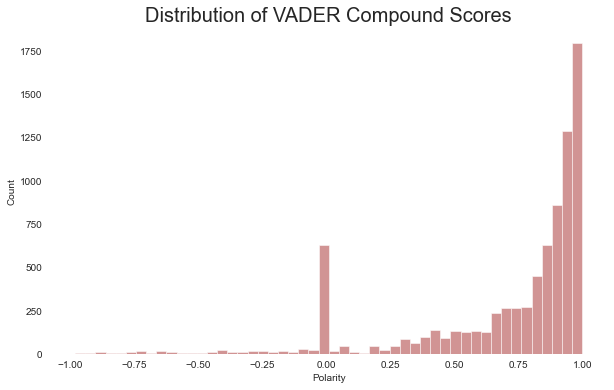

In [737]:
# Plot Vader Compound Scores
num_bins = 50
fig, ax = plt.subplots(figsize=(10,6))
ax.set_facecolor("White")
n, bins, patches = plt.hist(train2.VComp, num_bins, facecolor='brown', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Distribution of VADER Compound Scores', fontsize = 20)
plt.show();

In [739]:
# Get skew of VComp distribution
train2.VComp.skew()

-1.8111324474051664

Most of the descriptions have a positive sentiment and in most cases it is a strongly positive one. The data is therefore strongly negatively skewed.

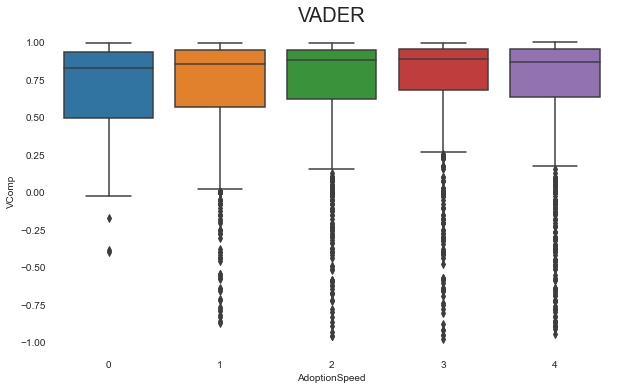

In [743]:
# Look at the Distribution of Polarity with regard to Ratings
fig, ax = plt.subplots(figsize = (10,6))
ax.set_facecolor("White")
sns.boxplot(x='AdoptionSpeed', y='VComp', data=train2)
plt.title("VADER",fontsize = 20)
plt.show();

There isn't much difference between the adoption speed indicators in terms of the sentiment of the descriptions. There is a slight curve in the plots so that the quickest and slowest adoptions seem to have slightly less positive sentiment than those categorised with adoption speed 1, 2 or 3. This might suggest that descriptions that are written with less positive wording about the dog's circumstances are likely to elicIt a quick response to 'rescue' the dog (perhaps if the dog has suffered in some way) or a much longer adoption time (perhaps if the less positive wording relates to a dog's temperament). A closer investigation of the wording used in each category would be needed to try to determine if this was the case.

In [745]:
quickest = train2[train2["AdoptionSpeed"] == 4]
slowest = train2[train2["AdoptionSpeed"] == 0]
middle = train2[(train2["AdoptionSpeed"] >0) & (train2["AdoptionSpeed"] <4)]

In [761]:
stopwords = list(STOPWORDS)

def gen_wordcloud(df):
    wc = WordCloud(stopwords=stopwords, background_color="white").generate(df)
    return wc

In [766]:
quickest_text = " ".join(d for d in quickest.Cleaned_text)
slowest_text = " ".join(d for d in slowest.Cleaned_text)
middle_text = " ".join(d for d in middle.Cleaned_text)

In [767]:
wordcloud_quickest = gen_wordcloud(quickest_text)
wordcloud_slowest = gen_wordcloud(slowest_text)
wordcloud_middle = gen_wordcloud(middle_text)

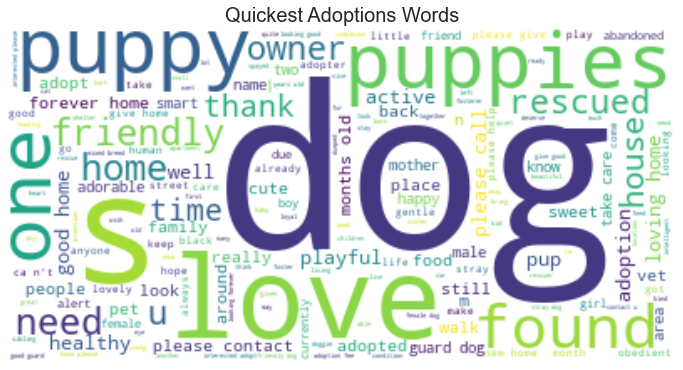

In [759]:
# Display the generated image: Hotels positive words
plt.figure(figsize=[12,10])
plt.title("Quickest Adoptions Words", fontsize = 20)
plt.imshow(wordcloud_quickest, interpolation='bilinear')
plt.axis("off")
plt.show()

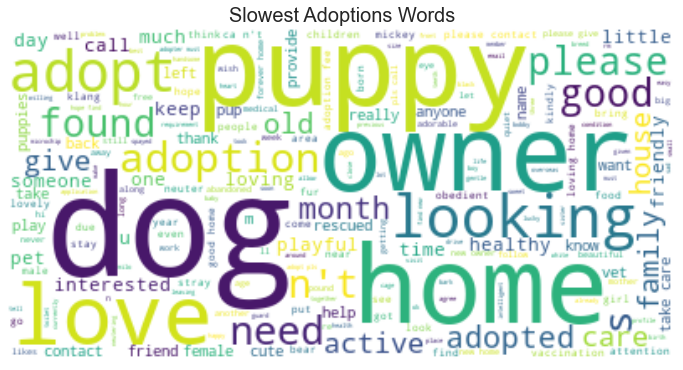

In [765]:
# Display the generated image: Hotels positive words
plt.figure(figsize=[12,10])
plt.title("Slowest Adoptions Words", fontsize = 20)
plt.imshow(wordcloud_slowest, interpolation='bilinear')
plt.axis("off")
plt.show()

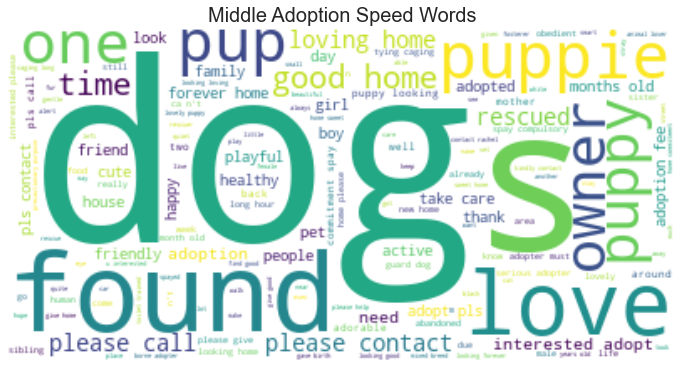

In [768]:
# Display the generated image: Hotels positive words
plt.figure(figsize=[12,10])
plt.title("Middle Adoption Speed Words", fontsize = 20)
plt.imshow(wordcloud_middle, interpolation='bilinear')
plt.axis("off")
plt.show()